## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [2]:
df = pd.read_csv('chap05/input/data-attendance-1.txt')
df.head()

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


## モデル式の記述

$\mu[n] = \beta_1 + \beta_2 A[n] + \beta_3 Score[n] $

$Y[n]$ ~ $ Normal( \mu[n], \sigma )$

## Stanでの実装

In [9]:
model_code="""
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  real<lower=0, upper=1> Y[N];
}
parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}
transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*A[n] + b3*Score[n];
}
model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}
generated quantities {
  real y_pred[N];
  real epsilon[N];
  for (n in 1:N) {
    y_pred[n] = normal_rng(mu[n], sigma);
    epsilon[n] = y_pred[n] - mu[n];  
  }
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], A=df.A, Score=df.Score/200, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d0d7a2793aebf17a8db26573daf4d5ed NOW.


Inference for Stan model: anon_model_d0d7a2793aebf17a8db26573daf4d5ed.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1            0.12  8.3e-4   0.03   0.05    0.1   0.12   0.15   0.19   1718    1.0
b2           -0.14  3.0e-4   0.01  -0.17  -0.15  -0.14  -0.13  -0.11   2538    1.0
b3            0.32  1.3e-3   0.05   0.22   0.29   0.32   0.36   0.43   1730    1.0
sigma         0.05  1.1e-4 5.6e-3   0.04   0.05   0.05   0.06   0.06   2385    1.0
mu[0]         0.24  4.0e-4   0.02    0.2   0.22   0.24   0.25   0.27   1865    1.0
mu[1]         0.22  2.6e-4   0.01   0.19   0.21   0.22   0.22   0.24   2579    1.0
mu[2]         0.33  1.7e-4 9.7e-3   0.31   0.32   0.33   0.33   0.35   3287    1.0
mu[3]         0.12  3.2e-4   0.02   0.09   0.11   0.12   0.13   0.15   2344    1.0
mu[4]         0.24  3.2e-4   0.02   0.21   0.23   0.24   0.25   

In [24]:
ms = fit.extract()
ms['epsilon'].shape

(4000, 50)

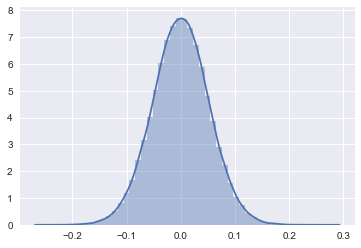

In [31]:
# 全サンプリングを区別せずにプロット
sns.distplot(ms['epsilon'].flatten())

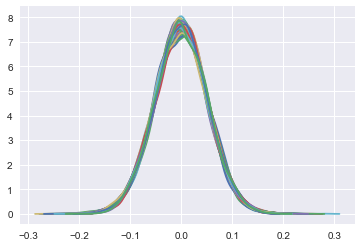

In [26]:
# 全サンプリングをIDごとに区別してプロット
for i in range(ms['epsilon'].shape[1]):
    sns.distplot(ms['epsilon'][:,i], hist=False)

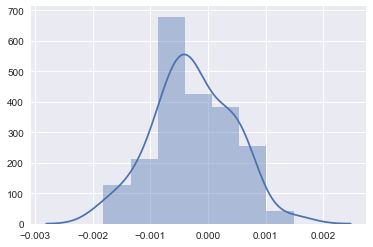

In [30]:
# サンプリングの平均値のヒストグラム
sns.distplot(ms['epsilon'].mean(axis=0))